In [95]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os
from datetime import datetime

from pyannote.audio import Pipeline
from pyannote.core import json

from matplotlib import pyplot as plt, lines
import seaborn as sns

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src import (
    downsample as downsamp_audio, 
    embedding_extractor as ee, 
    dimension_reducer as dr, 
    distance_metrics as dm, 
    downsample as ds,
    emb_manipulator as em
)

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
##Downsample audio to 16kHz
root_dir= "/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/053122_new_participants/"
audio_files = os.path.join(root_dir,"audio")

#make a folder with today's date for the downsampled audio
down_sample_dir = os.path.join(root_dir,
                               datetime.now().strftime('%Y_%m_%d') + '_16kHz')

if not os.path.exists(down_sample_dir):
    os.mkdir(down_sample_dir)

In [ ]:
ds.downsamp_audio(audio_files, down_sample_dir)

processing023.wav


In [12]:
##Diarize audio to find when mother is speaking and visualize it to choose label
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization")

diar_dir = os.path.join(root_dir,'audio',
                           datetime.now().strftime('%Y_%m_%d') + '_diarized')
if not os.path.exists(diar_dir):
    os.mkdir(diar_dir)

In [ ]:
for file in os.listdir(down_sample_dir):
    if file.endswith('wav'):
        diar = pipeline(os.path.join(down_sample_dir,file))
        json.dump_to(diar, os.path.join(diar_dir, os.path.splitext(file)[0]+'.json'))

In [16]:
diar_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/053122_new_participants/2022_05_31_diarized'

In [68]:
# Based on output of diarization, manually make speaker map to set which speaker we want
speaker_map = {'021':'SPEAKER_01', '022':'SPEAKER_00', 'BB003':'SPEAKER_00'}

In [73]:
diarized = {os.path.splitext(file)[0]:
            json.load_from(os.path.join(diar_dir,file)).label_timeline(
                speaker_map[os.path.splitext(file)[0]]) 
            for file in os.listdir(diar_dir)}

In [75]:
emb_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'
save_name = datetime.now().strftime('%Y_%m_%d') + '_emb.csv'
pyannote_emb = ee.pyannote_extract_directory(down_sample_dir, diarized,emb_dir,save_name,save=True)

Processing022.wav
Done


In [112]:
files = ['03016_diarized_pyv2.csv','2022_06_01_emb.csv']

emb_unscaled = pd.DataFrame()

for f in files:
    emb_unscaled = pd.concat([emb_unscaled,pd.read_csv(os.path.join(emb_dir,f), index_col=0)], ignore_index=True)

#emb_down_unscaled = em.resample_data(emb,1)

scaler = StandardScaler()
emb = pd.DataFrame(scaler.fit_transform(emb_unscaled.drop(columns='part_id')))
emb['part_id'] = emb_unscaled.part_id.astype('string').to_numpy()


In [167]:
min_dist=0.1
dim = 2
n_neighbors = 10


#max global structure
perplexity = 100
learning_rate = 200

###Run dimension reduction with different methods on the embeddings to establish a baseline before leaving any participants out
#Using tsne with perplexity=30 (default) since N/100<30, and learning rate of n/12. Random seed is 42 so the result is the same each time
emb_tsne = dr.run_tsne(emb, perplexity = perplexity, init='pca', learning_rate=learning_rate)

#run umap with default parameters
emb_umap = dr.run_umap(emb, n_neighbors=n_neighbors, min_dist=min_dist, metric='euclidean')


labels = emb.part_id


knn=50
knn_classes=4
subsetsize=700


[Text(0.5, 1.0, '      micro   meso  macro\numap  0.511  0.457  0.309')]

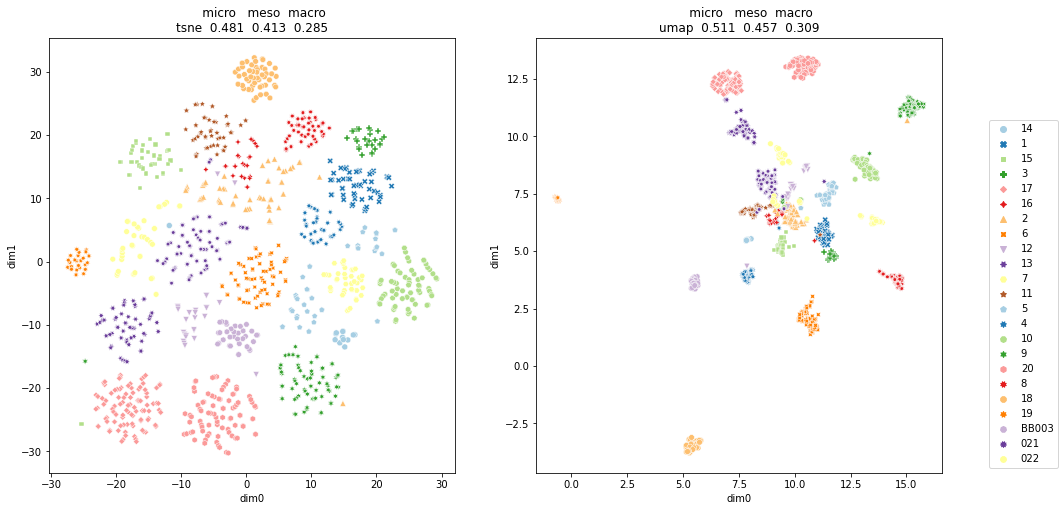

In [168]:
#we are always comparing to emb_down as our high-dimension embedding. 
high_dim = emb.drop(columns='part_id').to_numpy()
classes= emb.part_id.to_numpy() #extract the categories/labels

#compare tsne to embeddings
low_dim = emb_tsne.drop(columns='part_id').to_numpy()
dist_tsne = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)

#compare umap to embeddings
low_dim = emb_umap.drop(columns='part_id').to_numpy()
dist_umap = dm.embedding_quality(high_dim, low_dim, classes, knn=knn, knn_classes=knn_classes, subsetsize=subsetsize)


#create a dataframe of all distance metrics for each dimension method
dist = pd.DataFrame(np.vstack((dist_tsne, dist_umap)), columns = ['micro', 'meso', 'macro'], index = ['tsne', 'umap'])
dist = dist.round(decimals=3)

##plot 2 dimensions from each dimension reduction
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(16,8))

clust_plt_tsne = sns.scatterplot(x=emb_tsne.dim0, y=emb_tsne.dim1, ax=ax1, palette="Paired", hue=emb_tsne.part_id, style=emb_tsne.part_id, legend=False)
#ax1.legend(loc="lower center",bbox_to_anchor=(1.3,1), ncol=2)
clust_plt_tsne.set(title = str(dist[dist.index=='tsne']))

clust_plt_umap = sns.scatterplot(x=emb_umap.dim0, y=emb_umap.dim1, ax=ax2, palette="Paired", hue=emb_umap.part_id, style=emb_tsne.part_id)
ax2.legend(loc="lower center",bbox_to_anchor=(1.2,  0), ncol=1)
clust_plt_umap.set(title = str(dist[dist.index=='umap']))

In [169]:
haus_tsne = dm.hausdorff_distances(emb_tsne)
haus_umap = dm.hausdorff_distances(emb_umap)

Processing row 22, col 22


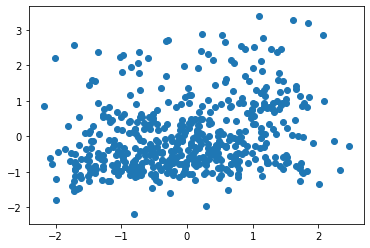

In [171]:
df_1 = pd.DataFrame(haus_tsne.to_numpy().flatten(), columns=['tsne']).dropna()
df_2 = pd.DataFrame(haus_umap.to_numpy().flatten(), columns=['umap']).dropna()

plt.scatter(df_1, df_2)